In [1]:

import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# pytorch lstm
import torch
from torch.utils.data import DataLoader, TensorDataset
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [1]:
import sklearn
sklearn.__version__

'1.5.2'

In [4]:
# 파일 호출
data_path: str = "../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

# 데이터 전처리

## feature selection

실제로 투자에 영향을 미칠 수 있을 만한 feature 중 각 거래소 별 데이터는 모든 데이터의 평균과 중복되는 데이터라고 판단하여 평균 데이터만 남기고 symbol 또한 평균만 남긴다.

## rolling window

주식 거래 및 암호화폐 거래 예측에서 rolling window(이동평균)은 일반적으로 사용되고 좋은 결과를 보이므로 채택하여 실험

## validation

비트코인 예측은 어디까지나 지금까지 본 적 없는 추세를 예측하는 것에 의미가 있다고 생각하여 아무리 시계열적 특성이 크게 적용되지 않는 tree 기반 모델일지라도 훈련 데이터 중 과거 80%를 훈련, 최신 20%를 검증에 사용하는 것이 성능 판단에 더 좋을 것이라 생각

## sequence 생성

LSTM 훈련을 위해 시계열 데이터를 sequence 형태로 변환

In [5]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

# 열 이름을 사전 순으로 정렬
df = df.reindex(sorted(df.columns), axis=1)

100%|██████████| 107/107 [00:01<00:00, 67.08it/s]


In [4]:
# 열 이름 중 coinbase-premium이 포함된 열을 제거
df_no_premium = df.loc[:, ~df.columns.str.contains("coinbase-premium")].copy()
# 열 이름에 BINANCE, BITFINEX, BYBIT, DERIBIT, FTX_GLOBAL, HTX_GLOBAL, HUOBI_GLOBAL, OKEX, OKX라는 문자 중 하나라도 포함된 열은 제거
df_all = df_no_premium.loc[:, ~df_no_premium.columns.str.contains("binance|bitmex|bitfinex|bybit|deribit|ftx_global|htx_global|huobi_global|okex|okx|gate_io|ftx|kraken")].copy()
# 열 이름 중 network-data는 모두 제거
df_no_net = df_all.loc[:, ~df_all.columns.str.contains("network-data")].copy()
# 열 이름 중 btc_usd, btc_busd, btc_usdt라는 문자 중 하나라도 포함된 열은 제거
df_no_spot = df_no_net.loc[:, ~df_no_net.columns.str.contains("btc_usd|btc_busd|btc_usdt|usd")].copy()
# hourly_market-data_open-interest_all_exchange_open_interest를 제거
df_missing = df_no_spot.loc[:, ~df_no_spot.columns.str.contains("hourly_market-data_open-interest_all_exchange_open_interest")].copy()
for i in df_missing.columns:
    print(i)

ID
_type
hourly_market-data_funding-rates_all_exchange_funding_rates
hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations
hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations
hourly_market-data_open-interest_all_exchange_all_symbol_open_interest
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio
hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume
target


In [5]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
}
df_last = df_missing[cols_dict.keys()].rename(cols_dict, axis=1).copy()
df_last.shape

(11552, 9)

In [6]:
# LSTM 훈련을 위한 sequence 생성
def create_sequences(data, targets, seq_length):
    X = []
    Y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])   # seq_length 만큼의 데이터
        Y.append(targets[i+seq_length])  # 그 다음 타임스텝의 타겟
    return np.array(X), np.array(Y)

In [7]:
# tree 기반 모델을 위한 shift featuer
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

In [8]:
# tree 기반 모델을 위해 rolling window를 사용하여 통계량을 계산
def rolling_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    windows: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 rolling feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        windows (List[int]): rolling windows
    Return:
        List[pd.Series]
    """
    df_rolling_dict = [
        df[conti_col].rolling(window=window).mean().rename(f"{conti_col}_rolling_{window}")
        for conti_col in conti_cols
        for window in windows
    ]
    return df_rolling_dict


In [9]:
# 단일 모델 실험을 통해 선택한 hyperparameter
sweep_config = {
    "method": "grid",
    "metric": {"name": "accuracy", "goal": "maximize"},
    "XG_parameters": {
        "n_estimators": {"values": [12]},
        "learning_rate": {"values": [0.3]},
        "max_depth": {"values": [3]},
        "min_child_weight": {"values": [1]},
        "subsample": {"values": [0.7]},
        "colsample_bytree": {"values": [0.7]},
        "gamma": {"values": [0]},
        "reg_lambda": {"values": [0.8]},
        "rolling_shift": {"values": [7]},
        "random_state": {"values": [42]},
    },
    "RF_parameters": {
        "n_estimators": {"values": [120]},
        "max_depth": {"values": [2]},
        "min_samples_split": {"values": [2]},
        "min_samples_leaf": {"values": [1]},
        "max_features": {"values": ["sqrt"]},
        "bootstrap": {"values": [True]},
        "class_weight": {"values": [None]}, 
        "rolling_shift": {"values": [7]},  
        "random_state": {"values": [42]},
    },
    "LSTM_parameters": {
        "seq_length": {"values": [8]},
        "n_epochs": {"values": [13]},
        "batch_size": {"values": [32]},
        "learning_rate": {"values": [0.001]},
        "hidden_size": {"values": [32]},
        "num_layers": {"values": [2]},
        "dropout_prob": {"values": [0.2]},
        "random_state": {"values": [42]},
    },
}

In [10]:
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]]

# 사용 모델 선정

## XGBoost

단일 모델로 baseline code (lightgbm)과 비교하여 약 3 퍼센트 포인트 정도의 정확도 향상

## RandomForestClassifier

단일 모델로 baseline code (lightgbm)과 비교하여 약 3 퍼센트 포인트 정도의 정확도 향상

## LSTM

단일 모델로서는 정확도 면에서 큰 향상을 이루지 못하였지만 tree 기반 모델이 불가능한 장기적인 추세 파악 및 주기성을 학습 가능하다고 판단하여 추가

## stacking ensemble

stock market prediction에 관한 연구(https://www.mdpi.com/2227-7072/11/3/94)에서 XGBoost, RandomForest, LSTM을 합친 모델이 좋은 성능을 기록.
해당 데이터와 목적(분류)에서도 좋은 성능을 보일 수 있을 것이라 판단하여 채택

In [11]:
# parameters 할당
XG_parameters = sweep_config["XG_parameters"]
RF_parameters = sweep_config["RF_parameters"]
LSTM_parameters = sweep_config["LSTM_parameters"]

# XGBoost parameters
XG_n_estimators = XG_parameters["n_estimators"]["values"][0]
XG_learning_rate = XG_parameters["learning_rate"]["values"][0]
XG_max_depth = XG_parameters["max_depth"]["values"][0]
XG_min_child_weight = XG_parameters["min_child_weight"]["values"][0]
XG_subsample = XG_parameters["subsample"]["values"][0]
XG_colsample_bytree = XG_parameters["colsample_bytree"]["values"][0]
XG_gamma = XG_parameters["gamma"]["values"][0]
XG_reg_lambda = XG_parameters["reg_lambda"]["values"][0]
XG_rolling_shift = XG_parameters["rolling_shift"]["values"][0]
XG_random_state = XG_parameters["random_state"]["values"][0]
XG_learning_rate = XG_parameters["learning_rate"]["values"][0]

# Random Forest parameters
RF_n_estimators = RF_parameters["n_estimators"]["values"][0]
RF_max_depth = RF_parameters["max_depth"]["values"][0]
RF_min_samples_split = RF_parameters["min_samples_split"]["values"][0]
RF_min_samples_leaf = RF_parameters["min_samples_leaf"]["values"][0]
RF_max_features = RF_parameters["max_features"]["values"][0]
RF_bootstrap = RF_parameters["bootstrap"]["values"][0]
RF_class_weight = RF_parameters["class_weight"]["values"][0]
RF_rolling_shift = RF_parameters["rolling_shift"]["values"][0]
RF_random_state = RF_parameters["random_state"]["values"][0]

# LSTM parameters
LSTM_seq_length = LSTM_parameters["seq_length"]["values"][0]
LSTM_n_epochs = LSTM_parameters["n_epochs"]["values"][0]
LSTM_batch_size = LSTM_parameters["batch_size"]["values"][0]
LSTM_learning_rate = LSTM_parameters["learning_rate"]["values"][0]
LSTM_hidden_size = LSTM_parameters["hidden_size"]["values"][0]
LSTM_num_layers = LSTM_parameters["num_layers"]["values"][0]
LSTM_dropout_prob = LSTM_parameters["dropout_prob"]["values"][0]
LSTM_random_state = LSTM_parameters["random_state"]["values"][0]

## XGBoost 모델 데이터 전처리 후 훈련 및 검증

In [12]:
# XGBoost Preprocessing

# shift feature 생성
shift_features = shift_feature(df_last, conti_cols, [_ for _ in range(1, XG_rolling_shift)])
# rolling feature 생성
rolling_features = rolling_feature(df_last, conti_cols, [XG_rolling_shift])

# concat 하여 df 에 할당
df_concat = pd.concat([df_last, pd.concat(shift_features, axis=1)], axis=1).copy()
df_concat2 = pd.concat([df_concat, pd.concat(rolling_features, axis=1)], axis=1).copy()


# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df_concat2["target"]
df_notnull = df_concat2.ffill().fillna(-999).assign(target = _target)


# train, test 분리
train_tree = df_notnull.loc[df_notnull["_type"] == "train"].drop(["ID", "_type"], axis=1)
test_tree = df_notnull.loc[df_notnull["_type"] == "test"].drop(["ID", "_type"], axis=1)

# train, valid 분리 (앞 80%는 train, 뒤 20%는 valid)
train_size = int(len(train_tree) * 0.8)
X_train_tree = train_tree.iloc[:train_size].drop("target", axis=1)
y_train_tree = train_tree.iloc[:train_size]["target"]
X_valid_tree = train_tree.iloc[train_size:].drop("target", axis=1)
y_valid_tree = train_tree.iloc[train_size:]["target"]

# standardization
scaler = StandardScaler()
X_train_tree_scale = scaler.fit_transform(X_train_tree)
X_valid_tree_scale = scaler.transform(X_valid_tree)

Accuracy: 0.453767
ROC AUC: 0.585800
Precision: 0.421124
Recall: 0.453767
F1: 0.421641


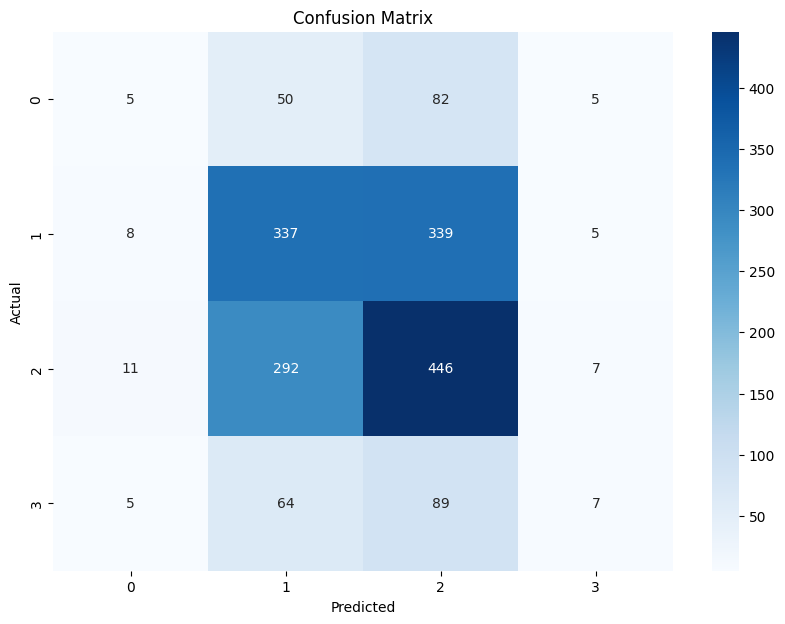

In [13]:
# XGBoost Model Training
# XGBClassifier 모델 생성
XGB_model = XGBClassifier(
    booster="gbtree",
    n_estimators=XG_n_estimators,
    eta=XG_learning_rate,
    max_depth=XG_max_depth,
    min_child_weight=XG_min_child_weight,
    subsample=XG_subsample,
    colsample_bytree=XG_colsample_bytree,
    gamma=XG_gamma,
    reg_lambda=XG_reg_lambda,
    random_state=XG_random_state,
    eval_metric="mlogloss",
)

# 모델 학습
XGB_model.fit(X_train_tree_scale, y_train_tree)

# valid 예측
valid_preds = XGB_model.predict(X_valid_tree_scale)
valid_preds_proba = XGB_model.predict_proba(X_valid_tree_scale)

# score check
accuracy = accuracy_score(y_valid_tree, valid_preds)
roc_auc = roc_auc_score(y_valid_tree, valid_preds_proba, multi_class="ovr")
precision = precision_score(y_valid_tree, valid_preds, average='weighted')
recall = recall_score(y_valid_tree, valid_preds, average='weighted')
f1 = f1_score(y_valid_tree, valid_preds, average='weighted')

# metric 출력
print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1: {f1:.6f}")

#confusion matrix
cm = confusion_matrix(y_valid_tree, valid_preds)
cm_df = pd.DataFrame(cm, index = [0,1,2,3], columns = [0,1,2,3])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## RandomForestClassifier 모델 데이터 전처리 후 훈련 및 검증

In [14]:
# Random Forest preprocessing

# shift feature 생성
shift_features = shift_feature(df_last, conti_cols, [_ for _ in range(1, RF_rolling_shift)])
# rolling feature 생성
rolling_features = rolling_feature(df_last, conti_cols, [RF_rolling_shift])

# concat 하여 df 에 할당
df_concat = pd.concat([df_last, pd.concat(shift_features, axis=1)], axis=1).copy()
df_concat2 = pd.concat([df_concat, pd.concat(rolling_features, axis=1)], axis=1).copy()


# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df_concat2["target"]
df_notnull = df_concat2.ffill().fillna(-999).assign(target = _target)


# train, test 분리
train_tree = df_notnull.loc[df_notnull["_type"] == "train"].drop(["ID", "_type"], axis=1)
test_tree = df_notnull.loc[df_notnull["_type"] == "test"].drop(["ID", "_type"], axis=1)

# train, valid 분리 (앞 80%는 train, 뒤 20%는 valid)
train_size = int(len(train_tree) * 0.8)
X_train_tree = train_tree.iloc[:train_size].drop("target", axis=1)
y_train_tree = train_tree.iloc[:train_size]["target"]
X_valid_tree = train_tree.iloc[train_size:].drop("target", axis=1)
y_valid_tree = train_tree.iloc[train_size:]["target"]

# standardization
scaler = StandardScaler()
X_train_tree_scale = scaler.fit_transform(X_train_tree)
X_valid_tree_scale = scaler.transform(X_valid_tree)

Accuracy: 0.459475
ROC AUC: 0.609093
Precision: 0.380024
Recall: 0.459475
F1: 0.414876


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


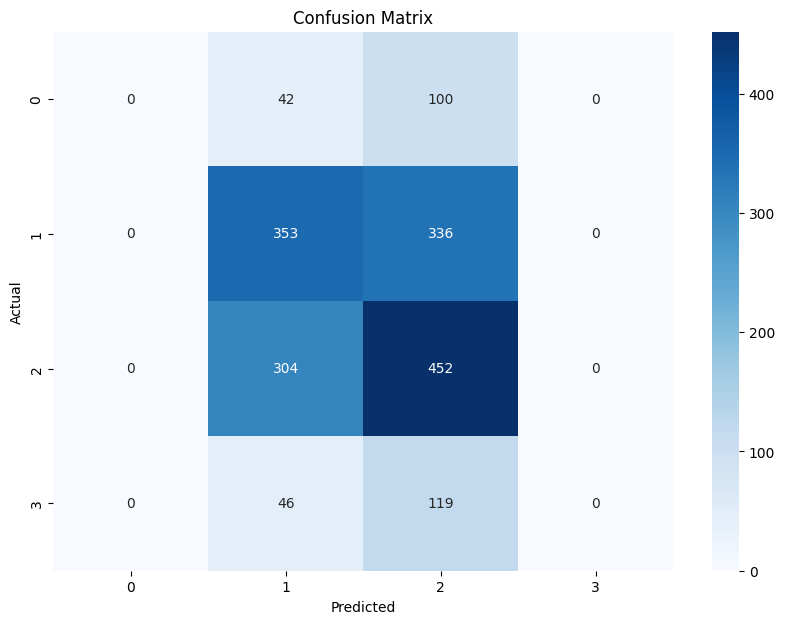

In [15]:
# Random Forest Model Training

# RandomForestClassifier 모델 생성
RF_model = RandomForestClassifier(
    n_estimators=RF_n_estimators,
    max_depth=RF_max_depth,
    min_samples_split=RF_min_samples_split,
    min_samples_leaf=RF_min_samples_leaf,
    max_features=RF_max_features,
    bootstrap=RF_bootstrap,
    class_weight=RF_class_weight,
    random_state=RF_random_state,
    n_jobs=-1,
)

# 모델 학습
RF_model.fit(X_train_tree_scale, y_train_tree)

# valid 예측
valid_preds = RF_model.predict(X_valid_tree_scale)
valid_preds_proba = RF_model.predict_proba(X_valid_tree_scale)

# score check
accuracy = accuracy_score(y_valid_tree, valid_preds)
roc_auc = roc_auc_score(y_valid_tree, valid_preds_proba, multi_class="ovr")
precision = precision_score(y_valid_tree, valid_preds, average='weighted')
recall = recall_score(y_valid_tree, valid_preds, average='weighted')
f1 = f1_score(y_valid_tree, valid_preds, average='weighted')

# metric 출력
print(f"Accuracy: {accuracy:.6f}")
print(f"ROC AUC: {roc_auc:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1: {f1:.6f}")

#confusion matrix
cm = confusion_matrix(y_valid_tree, valid_preds)
cm_df = pd.DataFrame(cm, index = [0,1,2,3], columns = [0,1,2,3])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## LSTM 모델 데이터 전처리 후 훈련 및 검증

In [16]:
# LSTM Preprocessing
# 훈련 데이터와 테스트 데이터 분리
train_df = df_last[df_last['_type'] == 'train']
test_df = df_last[df_last['_type'] == 'test']

# 훈련 데이터의 검증 데이터 unseen을 유지하기 위해 전반 80%를 훈련 데이터, 후반 20%를 검증 데이터로 분리
train_len = int(len(train_df) * 0.8)
train_df, val_df = train_df[:train_len], train_df[train_len:]

# 훈련 데이터의 feature를 X_train, X_val에 할당
X_train = train_df.drop(['ID', 'target', '_type'], axis=1)
X_val = val_df.drop(['ID', 'target', '_type'], axis=1)
X_test = test_df.drop(['ID', 'target', '_type'], axis=1)

# X_test에서 전체 예측을 위해 sequence 크기에 맞춰 X_val의 마지막 데이터를 추가
X_test = pd.concat([X_val[-LSTM_seq_length:], X_test])


# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_val_stand = scaler.transform(X_val)
X_test_stand = scaler.transform(X_test)

# 훈련, 검증 데이터의 target을 torch tensor로 변환
y_train = train_df['target']
y_val = val_df['target']
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

X_train_seq, y_train_seq = create_sequences(X_train_stand, y_train, LSTM_seq_length)
X_val_seq, y_val_seq = create_sequences(X_val_stand, y_val, LSTM_seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_stand, np.random.rand(len(X_test_stand)), LSTM_seq_length)

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long)

# tensor dataset 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# dataloader 생성
train_loader = DataLoader(train_dataset, batch_size=LSTM_batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=LSTM_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=LSTM_batch_size, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pytorch lstm model
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = torch.nn.Dropout(dropout_prob)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# 시드 고정
torch.manual_seed(LSTM_random_state)
np.random.seed(LSTM_random_state)

# 모델 초기화
LSTM_model = LSTMModel(
    input_size=X_train_tensor.shape[2],
    hidden_size=LSTM_hidden_size,
    num_layers=LSTM_num_layers,
    output_size=4,
    dropout_prob=LSTM_dropout_prob,
).to(device)

# 손실 함수 및 최적화 함수 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=LSTM_learning_rate)

# 메트릭 저장을 위한 리스트 초기화
train_losses = []
val_losses = []
val_accuracies = []
val_aucs = []
val_precisions = []
val_recalls = []
val_f1s = []

# dataloader에서 배치 단위로 데이터를 가져와 모델을 학습 및 검증 (각 epoch 마다 metric 그래프 출력)
for epoch in range(LSTM_n_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = LSTM_model(inputs)
        loss = criterion(outputs, labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{LSTM_n_epochs}], Loss: {loss.item()}')
    train_losses.append(loss.item())
    
    # 검증 데이터로 모델 성능을 확인 (loss, accuracy, loc_auc, precision, recall, f1 score)
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0
        y_true = []
        y_pred = []
        y_prob = []
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = LSTM_model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
        
        # 성능 지표 계산
        val_acc = correct / total
        val_auc = roc_auc_score(y_true, np.array(y_prob), multi_class='ovr')
        val_precision = precision_score(y_true, y_pred, average='weighted')
        val_recall = recall_score(y_true, y_pred, average='weighted')
        val_f1 = f1_score(y_true, y_pred, average='weighted')
        
        # 각 epoch 별 성능 지표 저장
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        val_aucs.append(val_auc)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

Epoch [1/13], Loss: 0.9010134339332581


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/13], Loss: 0.9069212079048157


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/13], Loss: 0.9110850691795349


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/13], Loss: 0.9148271679878235


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/13], Loss: 0.9190764427185059


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/13], Loss: 0.9237015247344971


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/13], Loss: 0.9292454123497009


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/13], Loss: 0.9351067543029785


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/13], Loss: 0.9383285641670227
Epoch [10/13], Loss: 0.937379777431488
Epoch [11/13], Loss: 0.9344387650489807
Epoch [12/13], Loss: 0.9297383427619934
Epoch [13/13], Loss: 0.927040159702301


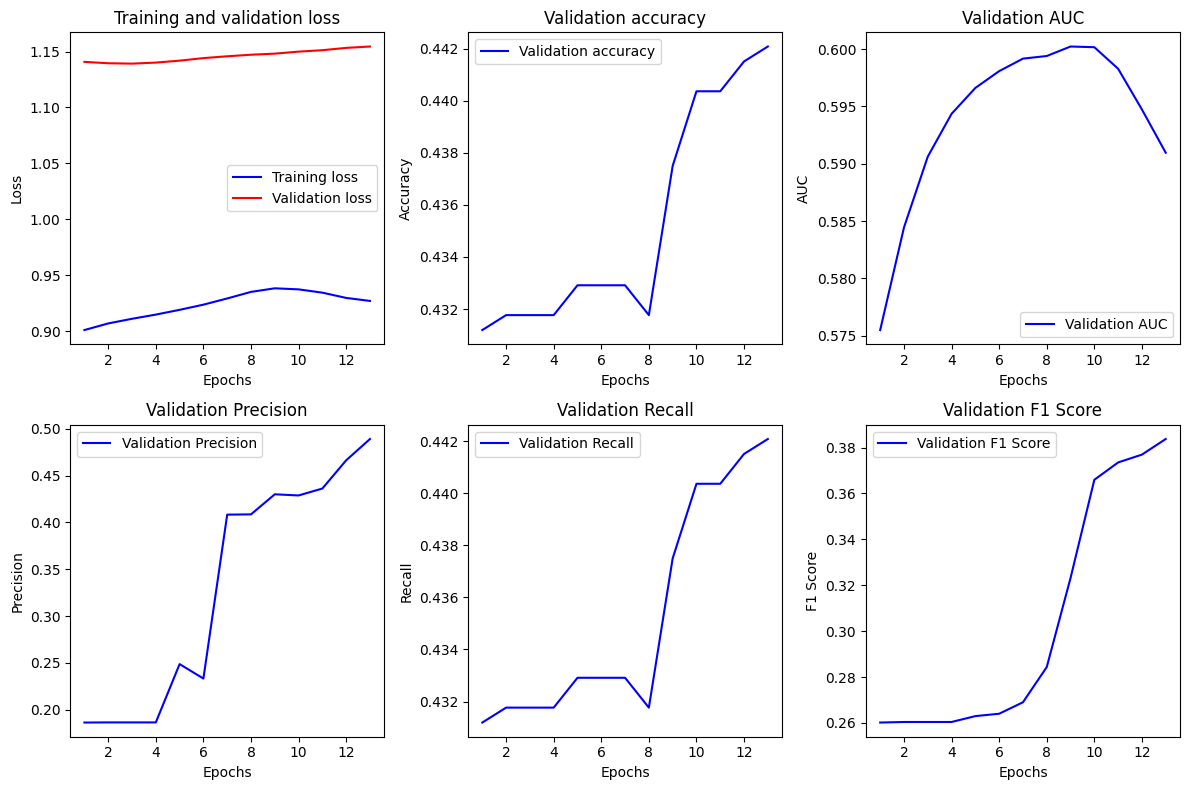

In [18]:
# 메트릭 그래프 그리기
epochs = range(1, LSTM_n_epochs + 1)

plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs, val_aucs, 'b', label='Validation AUC')
plt.title('Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, val_precisions, 'b', label='Validation Precision')
plt.title('Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, val_recalls, 'b', label='Validation Recall')
plt.title('Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(epochs, val_f1s, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# 가장 높은 accuracy를 달성한 epoch 찾기
best_epoch = np.argmax(val_accuracies)
best_epoch

# best_epoch에서의 metric 출력
print(f'Best Epoch: {best_epoch+1}')
print(f'Validation Loss: {val_losses[best_epoch]}')
print(f'Validation Accuracy: {val_accuracies[best_epoch]}')
print(f'Validation AUC: {val_aucs[best_epoch]}')
print(f'Validation Precision: {val_precisions[best_epoch]}')
print(f'Validation Recall: {val_recalls[best_epoch]}')
print(f'Validation F1 Score: {val_f1s[best_epoch]}')

Best Epoch: 13
Validation Loss: 1.1544972571459684
Validation Accuracy: 0.4420871559633027
Validation AUC: 0.590961514823543
Validation Precision: 0.48902125404340746
Validation Recall: 0.4420871559633027
Validation F1 Score: 0.38374899804563734


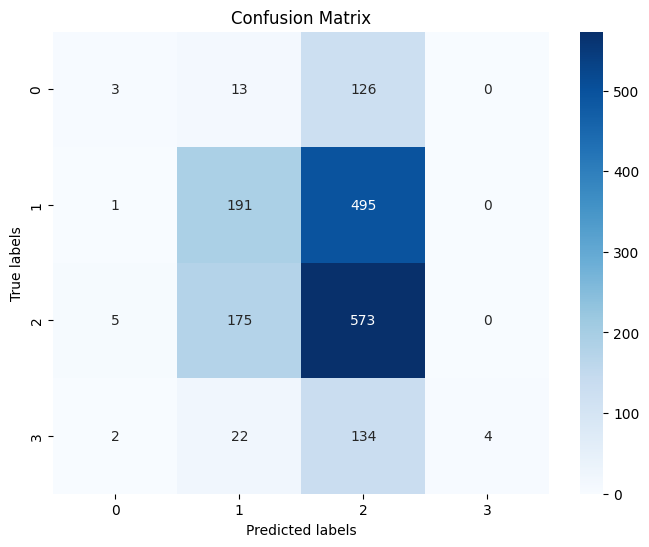

In [20]:
# Best Epoch에서의 confusion matrix 출력
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Stacking ensemble을 위한 메타 모델 훈련 및 검증

In [21]:
# stacking ensemble

y_prob = []
with torch.no_grad():
    # X_train_tensor를 사용하여 예측
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = LSTM_model(inputs)
        y_prob.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

X_train_meta_scale = X_train_tree_scale[LSTM_seq_length:]

# XGBoost, Random Forest, LSTM의 예측값을 feature로 사용
# train에서 예측 길이를 맞추기 위해 XGB, RF의 처음 LSTM_seq_length개 예측값을 제거
X_train_stack = np.concatenate([
    XGB_model.predict_proba(X_train_meta_scale),
    RF_model.predict_proba(X_train_meta_scale),
    y_prob
], axis=1)

print(X_train_stack.shape)

# 스태킹을 위한 메타 모델로 로지스틱 회귀 사용
meta_model = LogisticRegression(random_state=42, max_iter=20)

# 메타 모델 학습
meta_model.fit(X_train_stack, y_train[LSTM_seq_length:])

# 검증 데이터에 대해 예측
y_val_prob = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = LSTM_model(inputs)
        y_val_prob.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

X_val_meta_scale = X_valid_tree_scale[LSTM_seq_length:]

# 검증 데이터의 예측값을 feature로 사용
X_val_stack = np.concatenate([
    XGB_model.predict_proba(X_val_meta_scale),
    RF_model.predict_proba(X_val_meta_scale),
    y_val_prob
], axis=1)

# 메타 모델을 사용하여 검증 데이터 예측
y_val_pred = meta_model.predict(X_val_stack)

# 검증 데이터의 metric 출력
accuracy = accuracy_score(y_valid_tree[LSTM_seq_length:], y_val_pred)
roc_auc = roc_auc_score(y_valid_tree[LSTM_seq_length:], meta_model.predict_proba(X_val_stack), multi_class='ovr')
precision = precision_score(y_valid_tree[LSTM_seq_length:], y_val_pred, average='weighted')
recall = recall_score(y_valid_tree[LSTM_seq_length:], y_val_pred, average='weighted')
f1 = f1_score(y_valid_tree[LSTM_seq_length:], y_val_pred, average='weighted')

print(f'Accuracy: {accuracy:.6f}')
print(f'ROC AUC: {roc_auc:.6f}')
print(f'Precision: {precision:.6f}')
print(f'Recall: {recall:.6f}')
print(f'F1: {f1:.6f}')

(7000, 12)
Accuracy: 0.435780
ROC AUC: 0.592820
Precision: 0.421538
Recall: 0.435780
F1: 0.422437


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


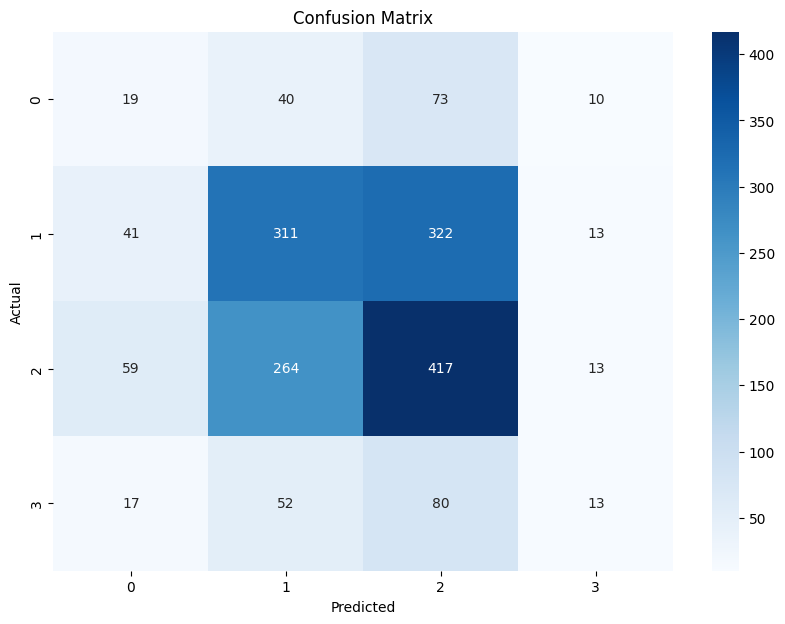

In [22]:
# confusion matrix
cm = confusion_matrix(y_valid_tree[LSTM_seq_length:], y_val_pred)
cm_df = pd.DataFrame(cm, index = [0,1,2,3], columns = [0,1,2,3])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# 각 모델을 전체 훈련 데이터를 활용하여 재훈련

In [23]:
# XGB 전체 데이터에 대해 재훈련

# XGBoost Preprocessing

# shift feature 생성
shift_features = shift_feature(df_last, conti_cols, [_ for _ in range(1, XG_rolling_shift)])
# rolling feature 생성
rolling_features = rolling_feature(df_last, conti_cols, [XG_rolling_shift])

# concat 하여 df 에 할당
df_concat = pd.concat([df_last, pd.concat(shift_features, axis=1)], axis=1).copy()
df_concat2 = pd.concat([df_concat, pd.concat(rolling_features, axis=1)], axis=1).copy()

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df_concat2["target"]
df_notnull = df_concat2.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df_notnull.loc[df["_type"]=="train"].drop(columns=["_type"]).copy()
test_df = df_notnull.loc[df["_type"]=="test"].drop(columns=["_type"]).copy()

x_train = train_df.drop(["target", "ID"], axis = 1)
y_train_tree = train_df["target"].astype(int)

# standardization
scaler = StandardScaler()
x_train_tree = scaler.fit_transform(x_train)
x_test_tree = scaler.transform(test_df.drop(["target", "ID"], axis=1))

In [24]:
# XGBoost Model Training
# XGBClassifier 모델 생성
XGB_model = XGBClassifier(
    booster="gbtree",
    n_estimators=XG_n_estimators,
    eta=XG_learning_rate,
    max_depth=XG_max_depth,
    min_child_weight=XG_min_child_weight,
    subsample=XG_subsample,
    colsample_bytree=XG_colsample_bytree,
    gamma=XG_gamma,
    reg_lambda=XG_reg_lambda,
    random_state=XG_random_state,
    eval_metric="mlogloss",
)

# 모델 학습
XGB_model.fit(x_train_tree, y_train_tree)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=12,
              n_jobs=None, num_parallel_tree=None, ...)

In [25]:
# Random Forest 전체 데이터에 대해 재훈련
# Random Forest model 생성
RF_model = RandomForestClassifier(
    n_estimators=RF_n_estimators,
    max_depth=RF_max_depth,
    min_samples_split=RF_min_samples_split,
    min_samples_leaf=RF_min_samples_leaf,
    max_features=RF_max_features,
    bootstrap=RF_bootstrap,
    class_weight=RF_class_weight,
    random_state=RF_random_state,
    n_jobs=-1,
)

# 모델 학습
RF_model.fit(x_train_tree, y_train_tree)

RandomForestClassifier(max_depth=2, n_estimators=120, n_jobs=-1,
                       random_state=42)

In [26]:
# LSTM 전체 데이터에 대해 재훈련
# LSTM Preprocessing
# 훈련 데이터와 테스트 데이터 분리
train_df = df_last[df_last['_type'] == 'train']
test_df = df_last[df_last['_type'] == 'test']

# 훈련 데이터의 feature를 X_train, X_val에 할당
X_train = train_df.drop(['ID', 'target', '_type'], axis=1)
X_test = test_df.drop(['ID', 'target', '_type'], axis=1)

# X_test에서 전체 예측을 위해 sequence 크기에 맞춰 X_val의 마지막 데이터를 추가
X_test = pd.concat([X_train[-LSTM_seq_length:], X_test])

# X_test의 각 열 별 null 값을 해당 열의 평균값으로 대체
X_test = X_test.fillna(X_test.mean())

# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

# 훈련, 검증 데이터의 target을 torch tensor로 변환
y_train = train_df['target']
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_train_seq, y_train_seq = create_sequences(X_train_stand, y_train, LSTM_seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_stand, np.random.rand(len(X_test_stand)), LSTM_seq_length)

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.long)

# tensor dataset 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# dataloader 생성
train_loader = DataLoader(train_dataset, batch_size=LSTM_batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=LSTM_batch_size, shuffle=False)

In [27]:
# LSTM model 초기화
LSTM_model = LSTMModel(
    input_size=X_train_tensor.shape[2],
    hidden_size=LSTM_hidden_size,
    num_layers=LSTM_num_layers,
    output_size=4,
    dropout_prob=LSTM_dropout_prob,
).to(device)

# 손실 함수 및 최적화 함수 설정
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=LSTM_learning_rate)

# 모델 재학습
for epoch in range(LSTM_n_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = LSTM_model(inputs)
        loss = criterion(outputs, labels.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{LSTM_n_epochs}], Loss: {loss.item()}')

Epoch [1/13], Loss: 1.0823086500167847
Epoch [2/13], Loss: 1.085309386253357
Epoch [3/13], Loss: 1.0843636989593506
Epoch [4/13], Loss: 1.082094430923462
Epoch [5/13], Loss: 1.0782970190048218
Epoch [6/13], Loss: 1.0741946697235107
Epoch [7/13], Loss: 1.0698862075805664
Epoch [8/13], Loss: 1.065850853919983
Epoch [9/13], Loss: 1.0629216432571411
Epoch [10/13], Loss: 1.0591392517089844
Epoch [11/13], Loss: 1.0570552349090576
Epoch [12/13], Loss: 1.0537575483322144
Epoch [13/13], Loss: 1.0516796112060547


In [28]:
# stacking ensemble

y_prob = []
with torch.no_grad():
    # X_train_tensor를 사용하여 예측
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = LSTM_model(inputs)
        y_prob.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

X_train_meta_last = x_train_tree[LSTM_seq_length:]

# XGBoost, Random Forest, LSTM의 예측값을 feature로 사용
# train에서 예측 길이를 맞추기 위해 XGB, RF의 처음 LSTM_seq_length개 예측값을 제거
X_train_stack = np.concatenate([
    XGB_model.predict_proba(X_train_meta_last),
    RF_model.predict_proba(X_train_meta_last),
    y_prob
], axis=1)

print(X_train_stack.shape)

# 스태킹을 위한 메타 모델로 로지스틱 회귀 사용
meta_model = LogisticRegression(random_state=42, max_iter=20)

# 메타 모델 학습
meta_model.fit(X_train_stack, y_train[LSTM_seq_length:])

(8752, 12)


/home/ksy/anaconda3/envs/boostcamp11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=20, random_state=42)

In [29]:
def check_nan_values(arr, name):
    if np.isnan(arr).any():
        print(f"{name} contains NaN values.")
    else:
        print(f"{name} does not contain any NaN values.")


In [30]:
# test 데이터에 대해 예측
y_test_prob = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = LSTM_model(inputs)
        y_test_prob.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

X_test_meta_last = x_test_tree

# XGB_model 예측값에서 NaN 값 검사
xgb_proba = XGB_model.predict_proba(X_test_meta_last)
check_nan_values(xgb_proba, "XGB_model.predict_proba(X_test_meta_last)")

# RF_model 예측값에서 NaN 값 검사
rf_proba = RF_model.predict_proba(X_test_meta_last)
check_nan_values(rf_proba, "RF_model.predict_proba(X_test_meta_last)")

# y_test_prob에서 NaN 값 검사
y_test_prob_arr = np.array(y_test_prob)
check_nan_values(y_test_prob_arr, "y_test_prob")

print(y_test_prob)

XGB_model.predict_proba(X_test_meta_last) does not contain any NaN values.
RF_model.predict_proba(X_test_meta_last) does not contain any NaN values.
y_test_prob does not contain any NaN values.
[array([0.08041427, 0.3922874 , 0.44655287, 0.08074544], dtype=float32), array([0.07156394, 0.4120167 , 0.44381672, 0.0726027 ], dtype=float32), array([0.07404406, 0.41678023, 0.43170026, 0.07747553], dtype=float32), array([0.05923868, 0.44708923, 0.42971113, 0.06396093], dtype=float32), array([0.06783193, 0.43382606, 0.4248924 , 0.07344969], dtype=float32), array([0.06154124, 0.4454313 , 0.42592928, 0.06709825], dtype=float32), array([0.05735091, 0.4568694 , 0.42207843, 0.0637012 ], dtype=float32), array([0.05487356, 0.4664206 , 0.41639447, 0.06231131], dtype=float32), array([0.05626625, 0.46712825, 0.41192636, 0.06467908], dtype=float32), array([0.05409239, 0.47232467, 0.41104707, 0.06253584], dtype=float32), array([0.05727424, 0.46828404, 0.40805012, 0.06639162], dtype=float32), array([0.0584

# stacking ensemble을 통한 test 데이터에 대한 예측 수행 및 제출 파일 생성

In [33]:
# test 데이터의 예측값을 feature로 사용
X_test_stack = np.concatenate([
    XGB_model.predict_proba(X_test_meta_last),
    RF_model.predict_proba(X_test_meta_last),
    y_test_prob
], axis=1)

# 메타 모델을 사용하여 test 데이터 예측
y_test_pred = meta_model.predict(X_test_stack)

# test 데이터 예측값을 submission 파일로 저장
submission = pd.DataFrame({'ID': test_df['ID'], 'target': y_test_pred})
# target을 int로 변환
submission['target'] = submission['target'].astype(int)
submission.to_csv('stacking_submission.csv', index=False)